In [40]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


#### Load fit results

In [43]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=True) for ss in subjects]
fitting_type2 = 'gabor_solo_ridge_12ori_8sf_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False)  for ss in subjects]

# create ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

loading from /user_data/mmhender/image_stats_gabor/model_fits/S01/gabor_solo_ridge_12ori_8sf/Apr-14-2022_1508_07/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'average_image_reps', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'trial_subset', 'corr_each_feature', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn', 'use_pca_gabor_feats'])
loading from /user_data/mmhender/image_stats_gabor/model_fits/S02/gabor_solo_ridge_12ori_8sf/Apr-17-2022_1437_00/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'average_ima

#### Process results of permutation test, compute p-values

In [42]:
from utils import stats_utils
from plotting import summary_plots

p_voxels_orig = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real_orig = out[si]['val_r2']
    r2_shuff_orig = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_orig = np.mean(r2_real_orig[:,0,None]<=r2_shuff_orig[:,0,:], axis=1)
    _,pvals_fdr_orig = stats_utils.fdr_keepshape(p_orig, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_orig[si] = pvals_fdr_orig
    
# thresholding voxels based on the permutation test
p = np.concatenate(p_voxels_orig, axis=0)
abv_thresh = p<0.01


#### Get info about the Gabor feature space

In [24]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [25]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
assert(not(np.any(is_constant)))

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


#### Histograms of preferred features

In [26]:
n_vox = preferred_ori_corr.shape[0]
feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr[vv])
    ff = int(preferred_sf_corr[vv])
    feature_prefs_2dhist[vv,oo,ff] = 1

#### Now compute ROI-averaged response profiles
For each participant separately

In [27]:
avg_resp_profiles = np.zeros((n_subjects, n_rois, n_ori, n_sf))
for si in range(n_subjects):
    for ri in range(n_rois):        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)   
        avg_resp_profiles[si,ri,:,:] = np.mean(allcorr_reshaped[inds_this_roi,:,:], axis=0)

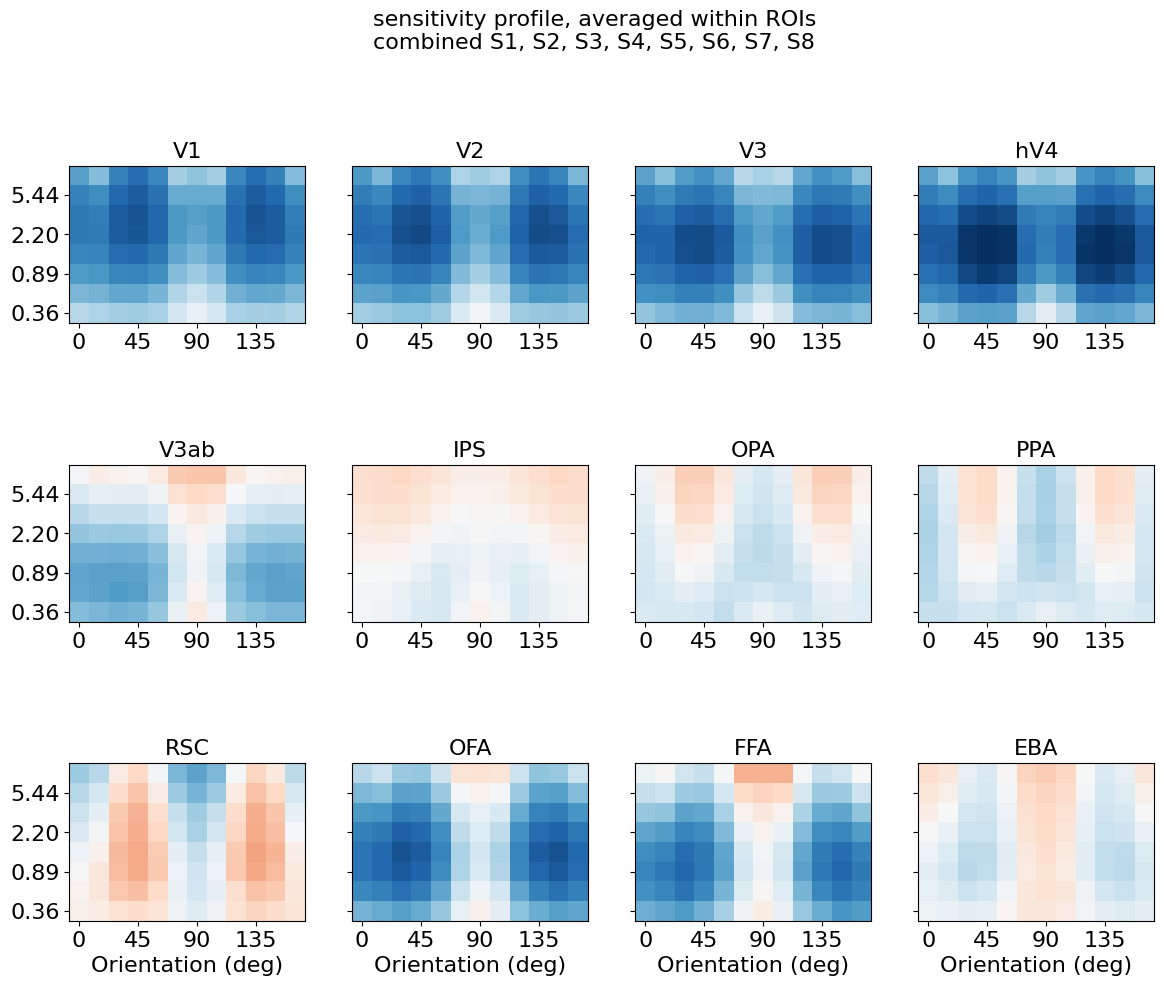

In [31]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(14,11))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npx))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

clims = [-0.6, 0.6]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=0)
    
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr,4)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        if rr==6:
            plt.ylabel('S.F. (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
    # plt.axis('off')
    
    # plt.colorbar()

    if rr>7:
        plt.xlabel('Orientation (deg)')
   
    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Feature_sensitivity_2d_allareas.pdf')
plt.savefig(fn2save)

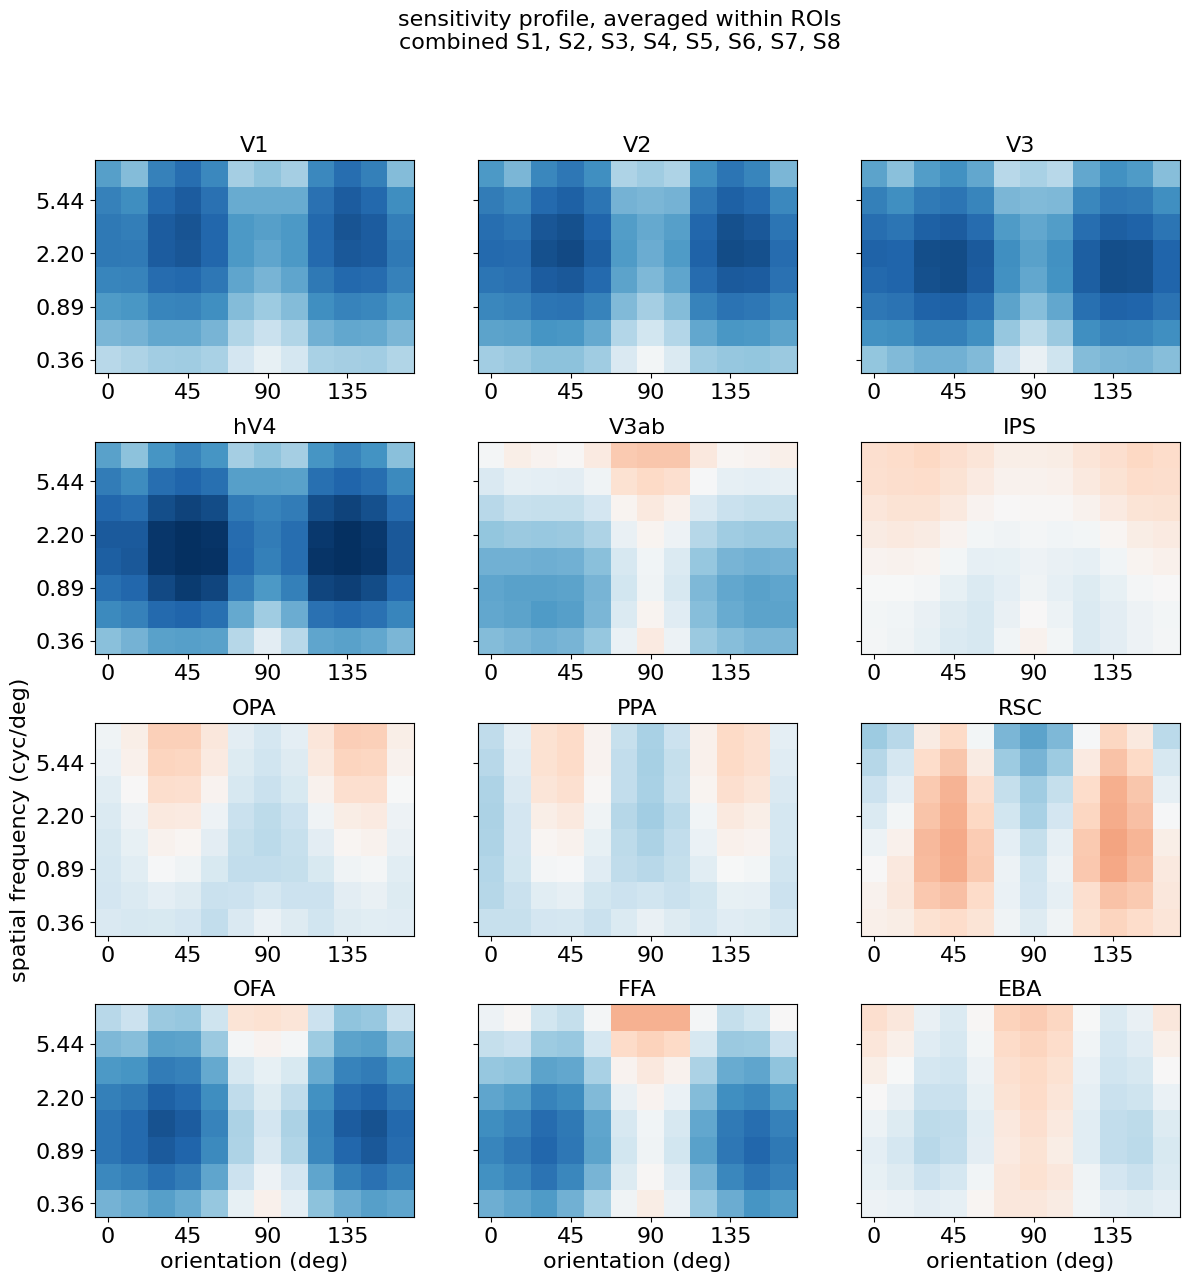

In [39]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(14,14))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil((n_rois)/npx))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

clims = [-0.6, 0.6]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=0)
    
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr,3)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        if rr==6:
            plt.ylabel('spatial frequency (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
    # plt.axis('off')
    
    # plt.colorbar()

    if rr>8:
        plt.xlabel('orientation (deg)')
   
    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Feature_sensitivity_2d_allareas.pdf')
plt.savefig(fn2save)

['OPA' 'PPA' 'RSC']
['OFA' 'FFA']


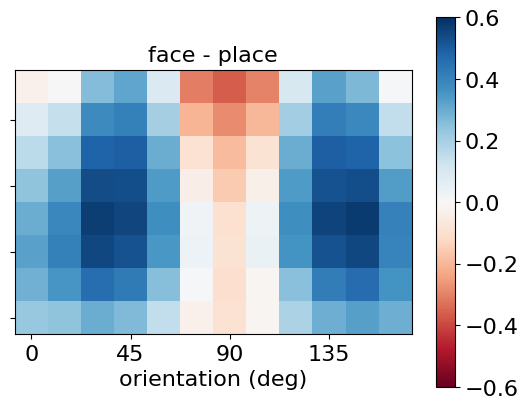

In [10]:
rinds1 = np.array([6,7,8])
rinds2 = np.array([9,10])
print(np.array(roi_names)[rinds1])
print(np.array(roi_names)[rinds2])
      

vals2 = np.mean(np.mean(avg_resp_profiles[:,rinds2,:,:], axis=0), axis=0)
vals1 = np.mean(np.mean(avg_resp_profiles[:,rinds1,:,:], axis=0), axis=0)
vals = vals2 - vals1

clims = [-0.6, 0.6]
plt.figure()
plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
sf_ticks = sf_unique[[0,2,4,6]].round(2)
if np.mod(rr,4)==0:
    plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
    plt.ylabel('spatial frequency (cyc/deg)')
else:
    plt.yticks(np.array([0,2,4,6])+0.5,[])
plt.axis('square')
plt.xlim([0,12])
plt.ylim([0,8])
# plt.axis('off')
plt.colorbar()

plt.xlabel('orientation (deg)')

plt.title('face - place')

fn2save = os.path.join(default_paths.fig_path, 'Feature_sensitivity_face-place.pdf')
plt.savefig(fn2save)

In [11]:
default_paths.fig_path

'/user_data/mmhender/image_stats_gabor/figures'

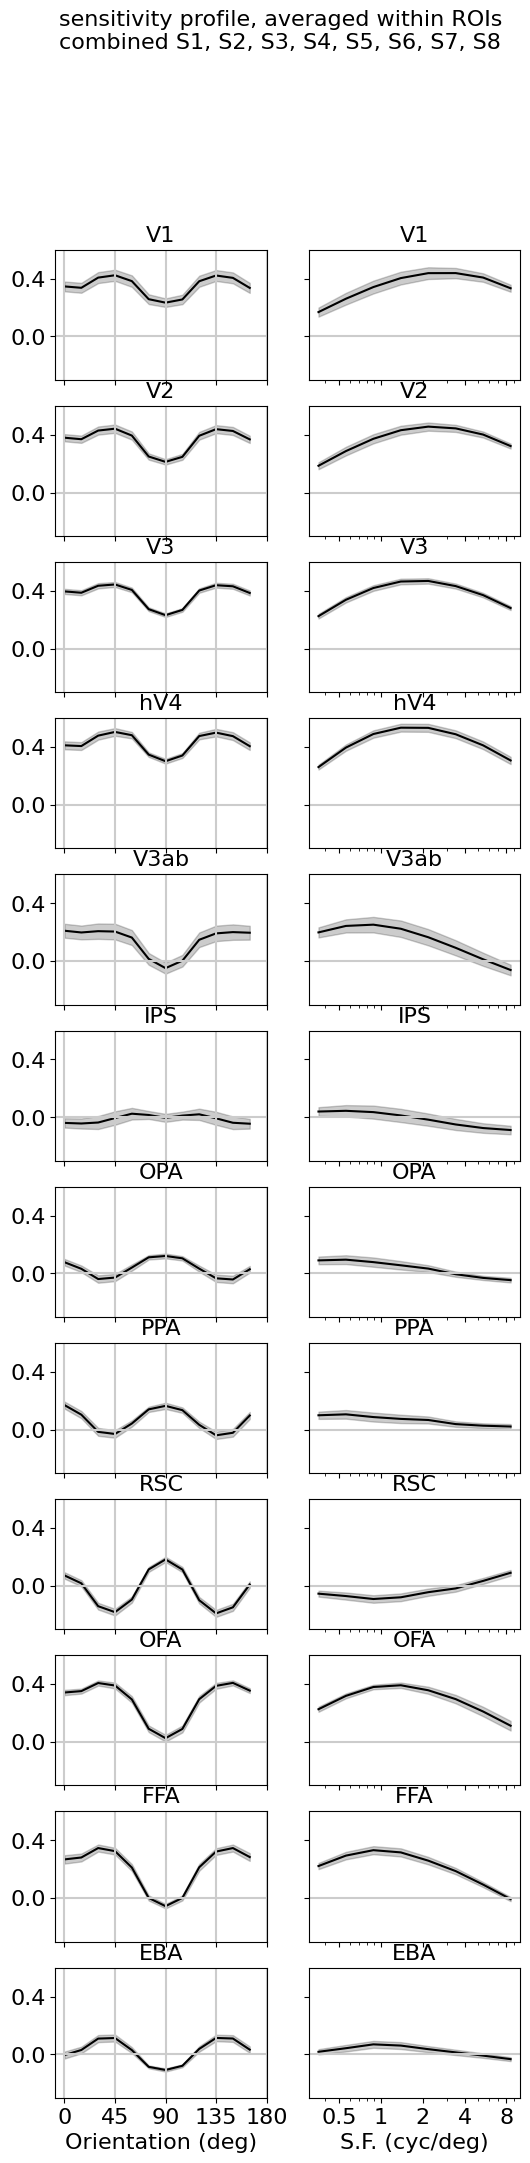

In [37]:
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(6,24))

npy = 2;

# ylims = [-0.6, 0.6]
# yticks = np.arange(-0.6, 0.61, 0.3)
ylims = [-0.3, 0.6]
# yticks = np.arange(-0.3, 0.61, 0.3)
yticks = [0, 0.4]

pi=0
# rois2plot = [0,7,8,10]
rois2plot = np.arange(n_rois)
npx = len(rois2plot)


for ri, rr in enumerate(rois2plot):
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)
    
    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=2)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(ori_unique,  meanvals, '-',color='k')
    plt.fill_between(ori_unique, meanvals-semvals, meanvals+semvals, alpha=0.2, color='k')
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim(ylims)
    
    if np.mod(pi,2):
        # plt.ylabel('corr coef')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, labels=[])

    if ri==(len(rois2plot)-1):
        plt.xlabel('Orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=1)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(sf_unique,  meanvals, '-',color='k')
    plt.fill_between(sf_unique, meanvals-semvals, meanvals+semvals, alpha=0.2, color='k')
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim(ylims)
    
    if np.mod(pi,2):
        # plt.ylabel('corr coef')
        plt.yticks()
    else:
        plt.yticks(yticks, labels=[])

    plt.gca().set_xscale('log')
    if ri==(len(rois2plot)-1):
        plt.xlabel('S.F. (cyc/deg)')
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
    
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

fn2save = os.path.join(default_paths.fig_path, 'Marginal_profiles_allareas.pdf')
plt.savefig(fn2save)


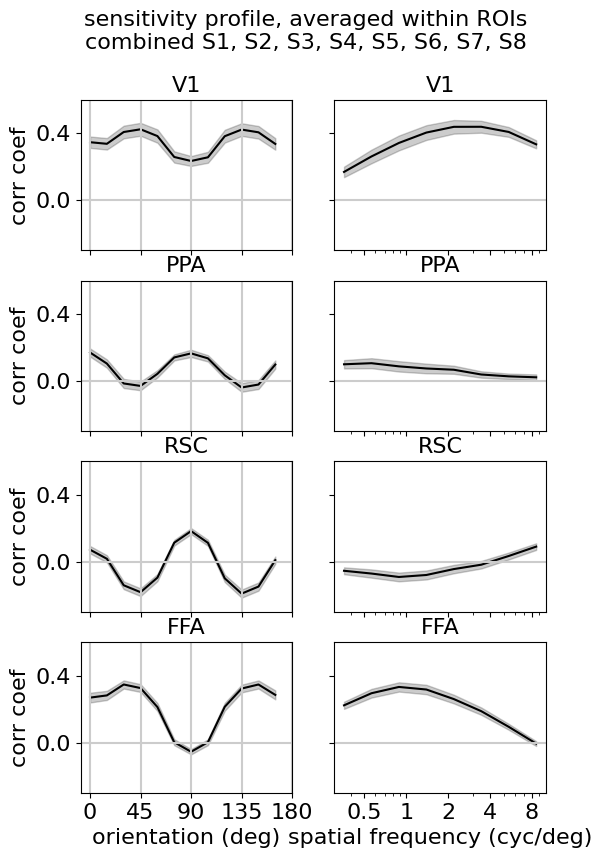

In [38]:
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(6,9))

npy = 2;

# ylims = [-0.6, 0.6]
# yticks = np.arange(-0.6, 0.61, 0.3)
ylims = [-0.3, 0.6]
# yticks = np.arange(-0.3, 0.61, 0.3)
yticks = [0, 0.4]

pi=0
rois2plot = [0,7,8,10]
# rois2plot = np.arange(n_rois)
npx = len(rois2plot)


for ri, rr in enumerate(rois2plot):
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)
    
    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=2)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(ori_unique,  meanvals, '-',color='k')
    plt.fill_between(ori_unique, meanvals-semvals, meanvals+semvals, alpha=0.2, color='k')
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim(ylims)
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, labels=[])

    if ri==(len(rois2plot)-1):
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=1)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(sf_unique,  meanvals, '-',color='k')
    plt.fill_between(sf_unique, meanvals-semvals, meanvals+semvals, alpha=0.2, color='k')
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim(ylims)
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks()
    else:
        plt.yticks(yticks, labels=[])

    plt.gca().set_xscale('log')
    if ri==(len(rois2plot)-1):
        plt.xlabel('spatial frequency (cyc/deg)')
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
    
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Marginal_profiles_selectedareas.pdf')
plt.savefig(fn2save)


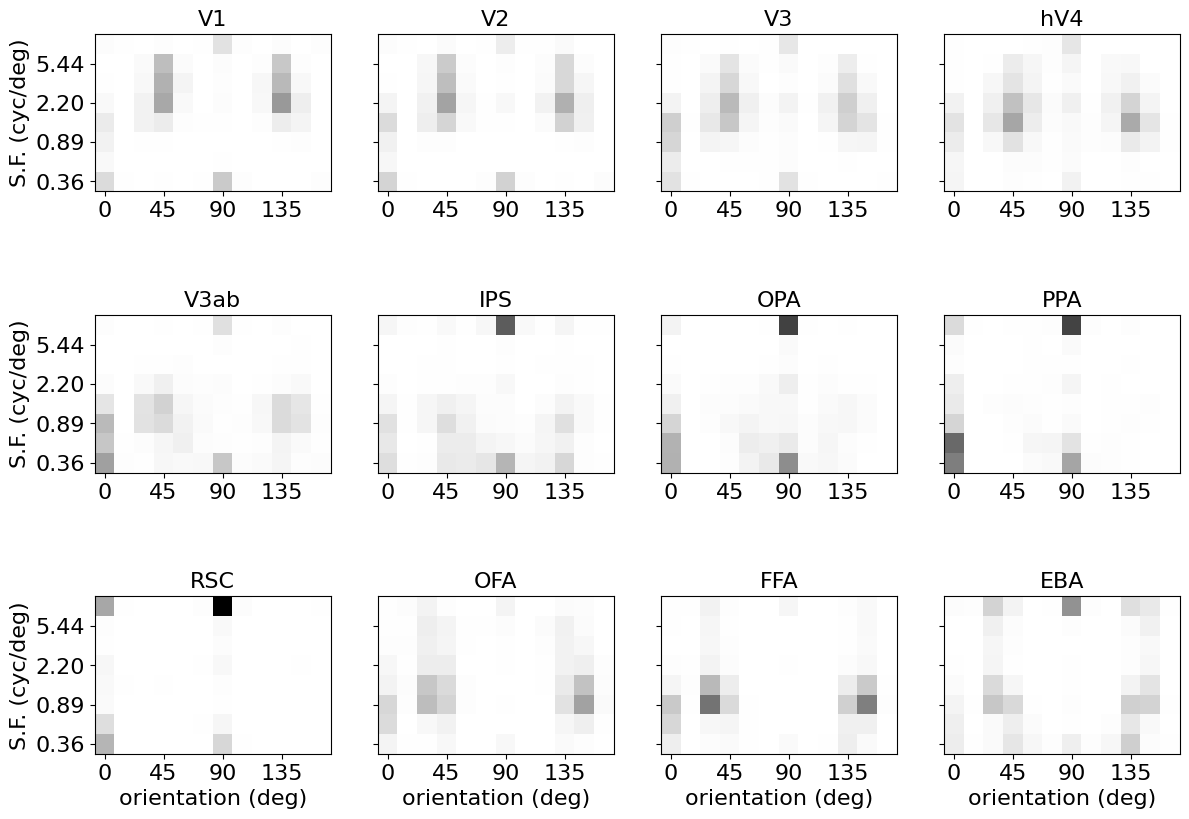

In [32]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(14,14))
# npx = 4;npy = 3;
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npx))

pi=0

clims = [0, 0.30]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    inds_this_roi = roi_def.get_indices(rr)
    inds_this_roi = inds_this_roi & abv_thresh 
    
    vals = np.mean(feature_prefs_2dhist[inds_this_roi,:,:], axis=0)
 
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr, npy)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        if np.mod(rr,4)==0:
            plt.ylabel('S.F. (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
   
    if rr>7:
        plt.xlabel('orientation (deg)')
    plt.title(roi_names[rr])

fn2save = os.path.join(default_paths.fig_path, 'Selectivity_2dhist_allareas.pdf')
plt.savefig(fn2save)

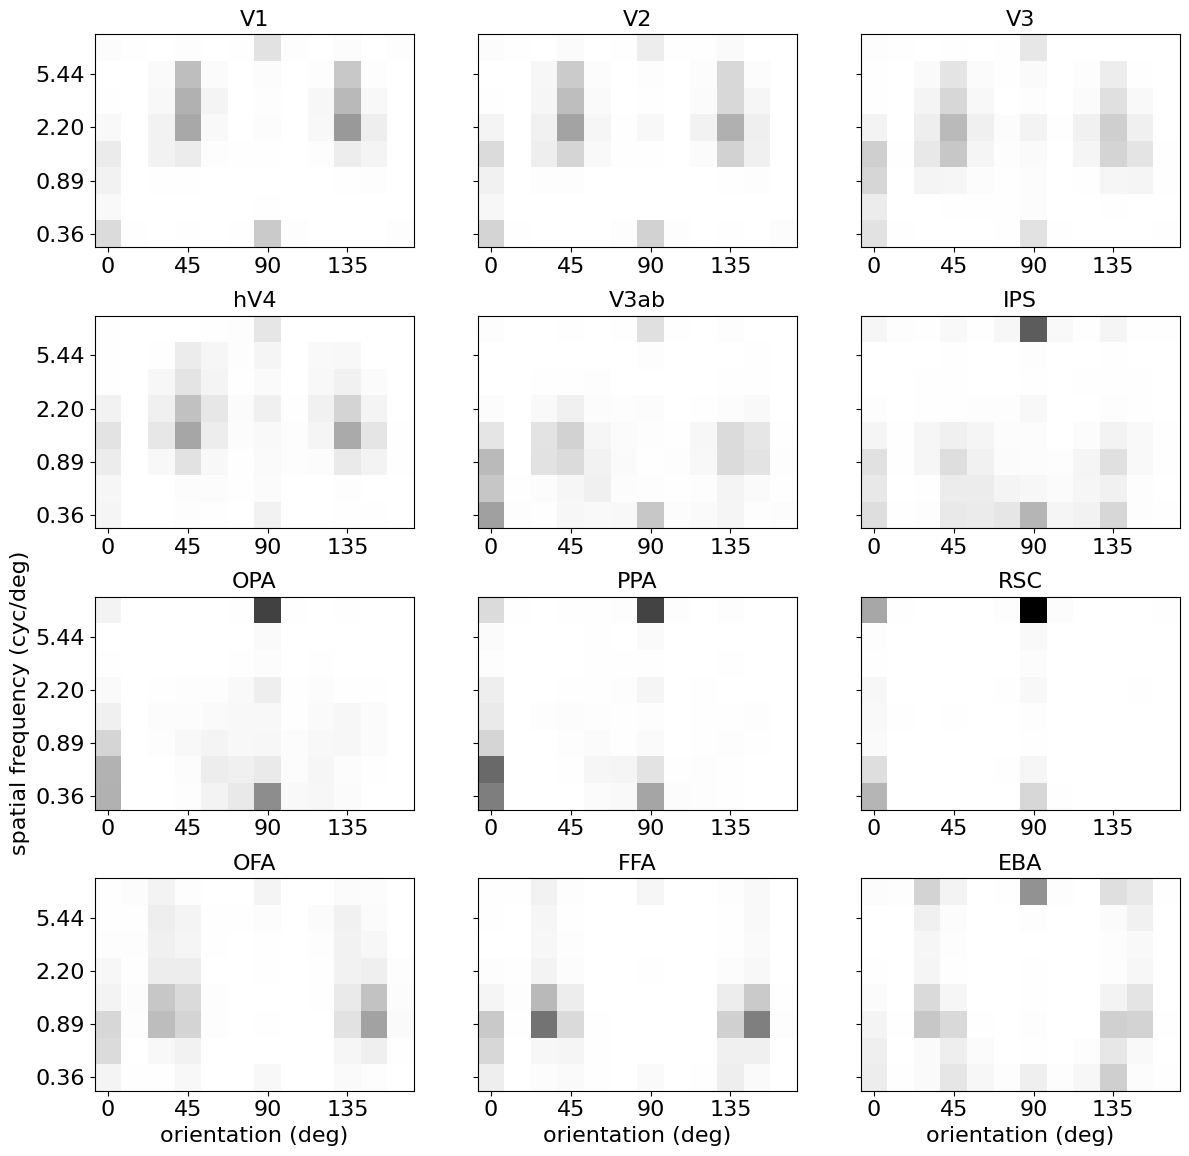

In [13]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(14,14))
# npx = 4;npy = 3;
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil((n_rois)/npx))

pi=0

clims = [0, 0.30]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    inds_this_roi = roi_def.get_indices(rr)
    inds_this_roi = inds_this_roi & abv_thresh 
    
    vals = np.mean(feature_prefs_2dhist[inds_this_roi,:,:], axis=0)
 
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr, npy)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        if rr==6:
            plt.ylabel('spatial frequency (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
   
    if rr>8:
        plt.xlabel('orientation (deg)')
    plt.title(roi_names[rr])

fn2save = os.path.join(default_paths.fig_path, 'Selectivity_2dhist_allareas.pdf')
plt.savefig(fn2save)

#### Plot average orientation sensitivity profiles for each ROI

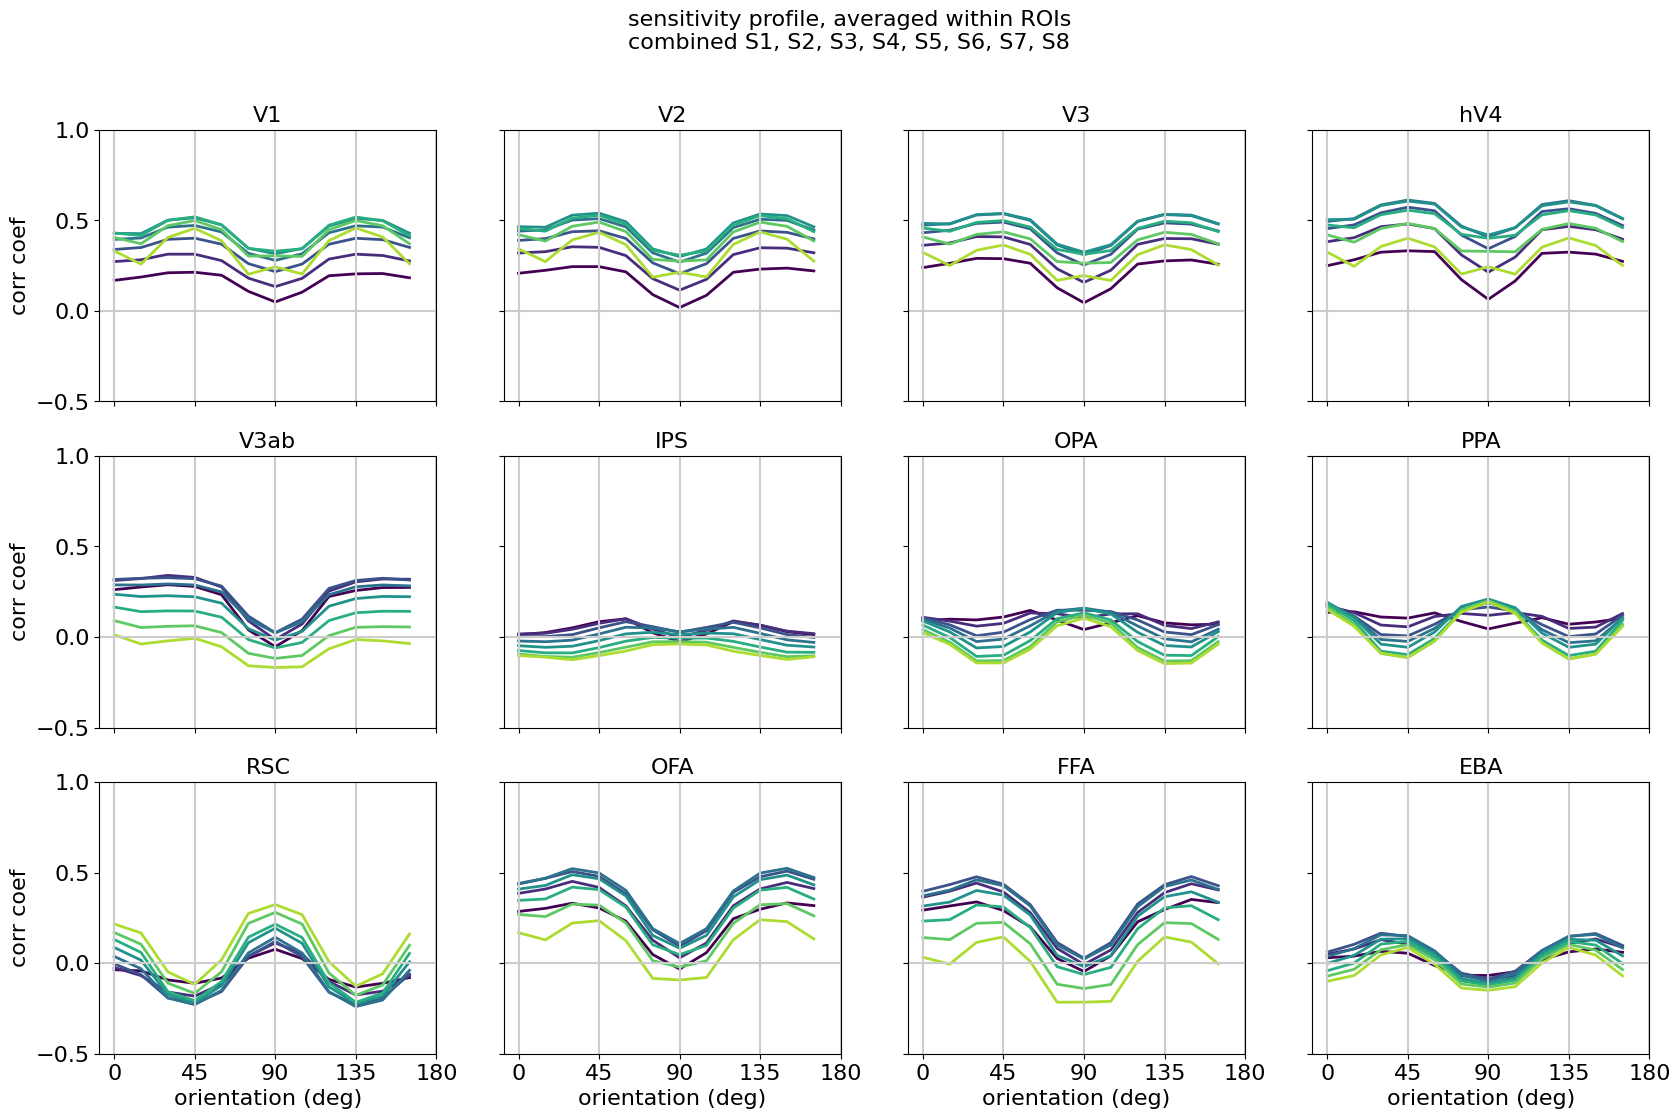

In [14]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=2)
    meanvals = np.mean(vals , axis=0)
   
    for sf in range(n_sf):
        vals = avg_resp_profiles[:,rr,:,sf]
        meanvals = np.mean(vals , axis=0)
       
        plt.plot(ori_unique,  meanvals, '-',color=colors[sf,:],linewidth=2)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(rr,4)==0:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))

    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    if pi>8:
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Orient_sensitivity_allareas.pdf')
plt.savefig(fn2save)

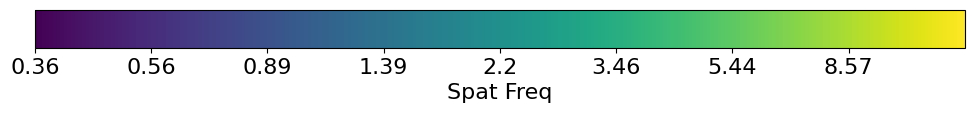

In [15]:
# make colorbar for spat freq color coding
import matplotlib

fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_sf)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', \
                                ticks=np.arange(n_sf))
cb1.set_ticklabels(sf_unique.round(2))
# cb1.set_xlim([0, 8])
cb1.set_label('Spat Freq')
fig.show()

fn2save = os.path.join(default_paths.fig_path, 'Freq_colorbar.pdf')
plt.savefig(fn2save)

#### Plot average spatial frequency sensitivity profiles for each ROI

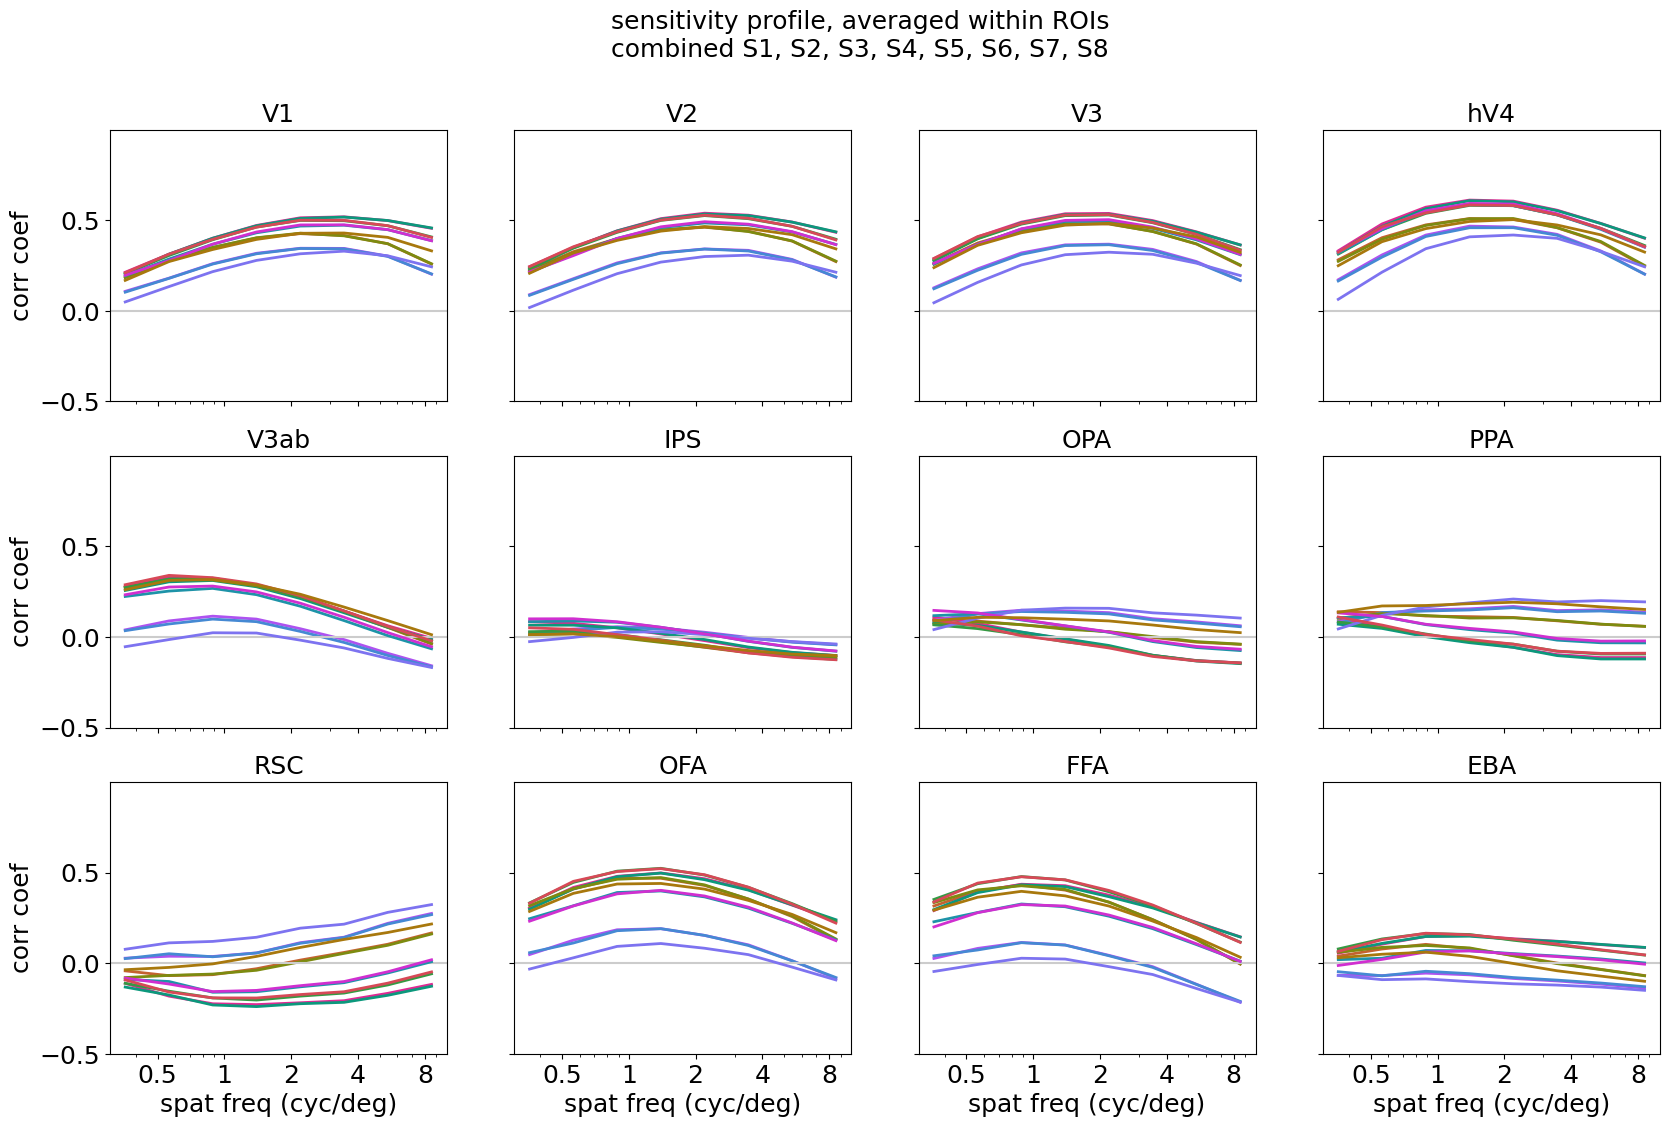

In [16]:
plot_utils.set_all_font_sizes(fs = 18)

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cmocean.cm.phase(np.linspace(0,1,n_ori+1))[0:-1,:]
# choose the order in which to layer the lines...some of them overlap almost completely, 
# so this makes it a little easier to see colors
zorders = np.arange(n_ori, 0, -1)
zorders[np.arange(1,12,2)]*=(-1)


pi=0
for rr in range(n_rois):
    
    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=1)
    meanvals = np.mean(vals , axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    pi+=1
    plt.subplot(npx,npy,pi)

    for oo in range(n_ori):
        vals = avg_resp_profiles[:,rr,oo,:]
        meanvals = np.mean(vals , axis=0)

        plt.plot(sf_unique,  meanvals, '-',color=colors[oo,:],linewidth=2, zorder=zorders[oo])
        
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if np.mod(pi,4)==1:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1, 0.5), [])
    plt.gca().set_xscale('log')
    if pi>8:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
        plt.xlabel('spat freq (cyc/deg)')
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Freq_sensitivity_allareas.pdf')
plt.savefig(fn2save)


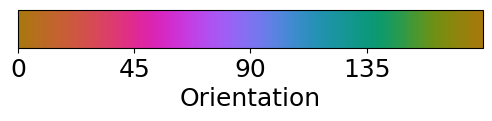

In [17]:
# make colorbar for orientation color coding
import matplotlib

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cmocean.cm.phase
norm = matplotlib.colors.Normalize(vmin=0, vmax=180)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', \
                                ticks=[0, 45, 90, 135])
cb1.set_label('Orientation')
fig.show()

fn2save = os.path.join(default_paths.fig_path, 'Orient_colorbar.pdf')
plt.savefig(fn2save)

#### Plot sensitivity profiles for a selected few areas

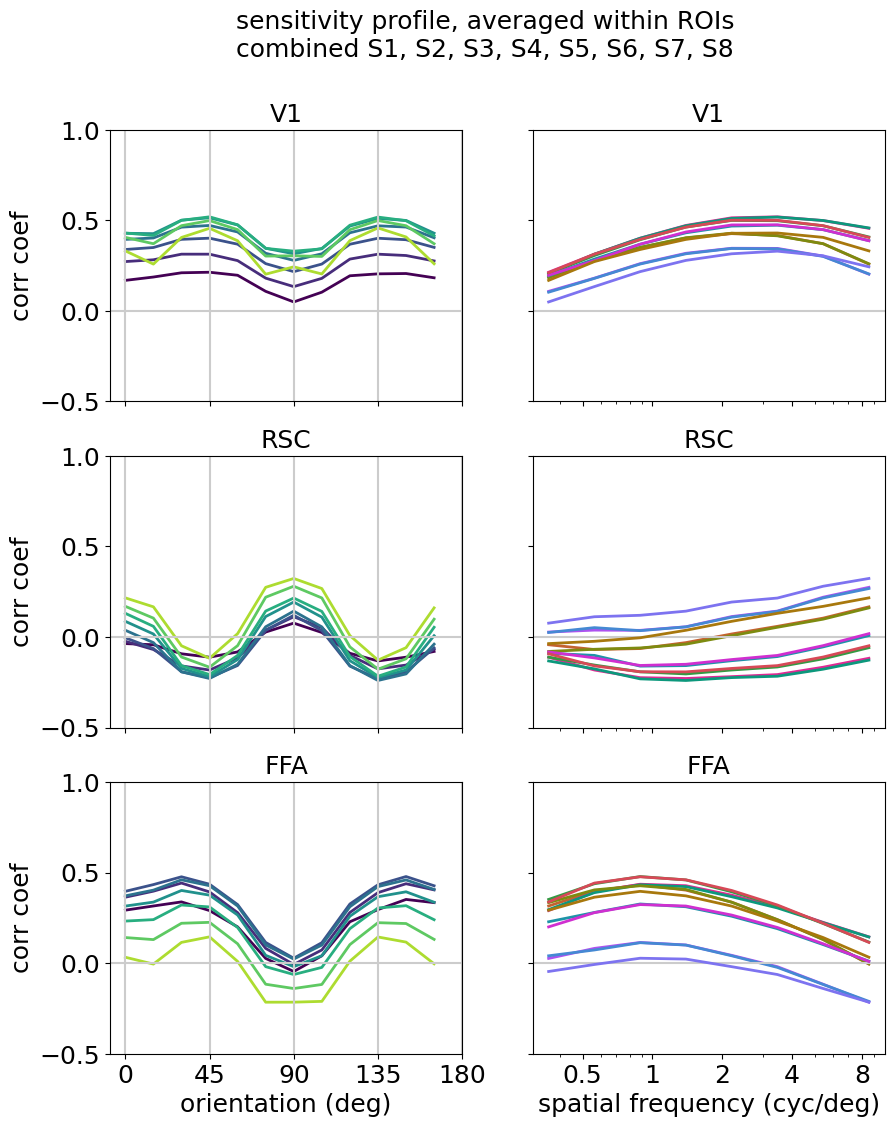

In [18]:
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(10,12))
npx = 3;
npy = 2;

sf_colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

orient_colors = cmocean.cm.phase(np.linspace(0,1,n_ori+1))[0:-1,:]
# choose the order in which to layer the lines...some of them overlap almost completely, 
# so this makes it a little easier to see colors
zorders = np.arange(n_ori, 0, -1)
zorders[np.arange(1,12,2)]*=(-1)


pi=0
rois2plot = [0,8,10]
for rr in rois2plot:
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    for sf in range(n_sf):
        vals = avg_resp_profiles[:,rr,:,sf]
        meanvals = np.mean(vals , axis=0)
        plt.plot(ori_unique,  meanvals, '-',color=sf_colors[sf,:],linewidth=2)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    if pi>4:
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(roi_names[rr]))
    
    pi+=1
    plt.subplot(npx,npy,pi)

    # choose the order in which to layer the lines...some of them overlap almost completely, 
    # so this makes it a little easier to see colors
    zorders = np.arange(n_ori, 0, -1)
    zorders[np.arange(1,12,2)]*=(-1)
    for oo in range(n_ori):
        vals = avg_resp_profiles[:,rr,oo,:]
        meanvals = np.mean(vals , axis=0)
        plt.plot(sf_unique,  meanvals, '-',color=orient_colors[oo,:],linewidth=2, \
                 zorder=zorders[oo])
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(pi,2):
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    plt.gca().set_xscale('log')
    if pi>4:
        plt.xlabel('spatial frequency (cyc/deg)')
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
    
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Gabor_profiles_selectedareas.pdf')
plt.savefig(fn2save)


#### Compute radial bias: first gather our pRF pars

In [19]:
prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg

#### Now make a plot of the correlation bw polar angle pref and orient pref

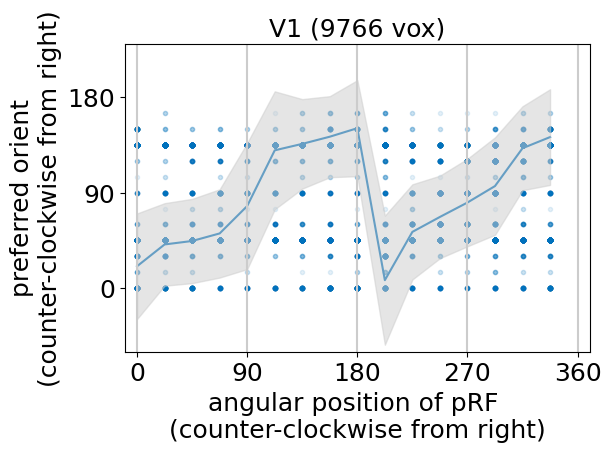

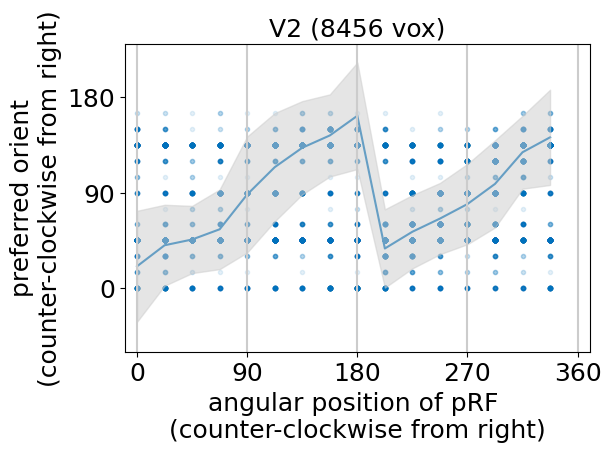

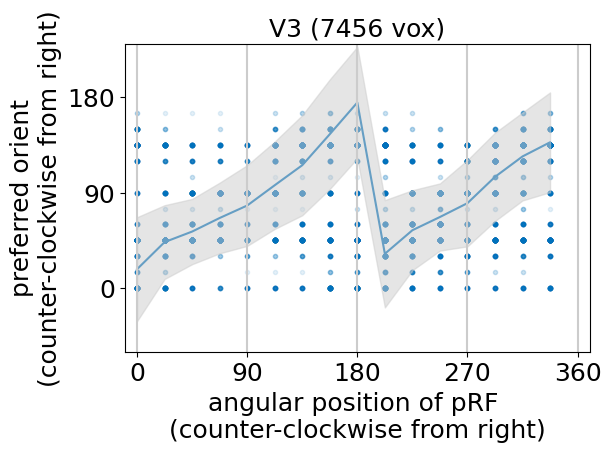

In [20]:
color = '#0071bc'
plt.rcParams['pdf.fonttype']=42

for vv in [0,1,2]:

    r2_cutoff = 0.01
    val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
    abv_thresh = val_r2>r2_cutoff

    vinds = roi_def.get_indices(vv) & abv_thresh

    plt.figure(figsize=(6,4))

    xvals = np.round(angle_fwrf[vinds],1)
    unique_angles, counts = np.unique(xvals, return_counts=True)

    # change the coordinate system of orientation here, so that it matches with 
    # the angular positions (go counter-clockwise from right)
    yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)  
    # yvals = np.mod(90 - ori_unique[preferred_ori_weights[vinds].astype(int)], 180)  
    yvals_adj = yvals/180*2*np.pi # for circmean/circstd, need range 0-2pi

    ymean = np.array([scipy.stats.circmean(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)
    ystd = np.array([scipy.stats.circstd(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)

    plt.plot(xvals, yvals,'.',color=color, alpha=0.10)

    # plt.errorbar(unique_angles, ymean, ystd, color='k',zorder=10)
    plt.plot(unique_angles, ymean,'-',color=color)
    plt.fill_between(unique_angles, ymean+ystd, ymean-ystd, color=[0.8, 0.8, 0.8] ,alpha=0.5, zorder=10)

    for ii in np.arange(0,370,90):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])

    plt.xticks(np.arange(0,370,90));
    plt.yticks(np.arange(0,190,90));
    plt.xlabel('angular position of pRF \n(counter-clockwise from right)')
    plt.ylabel('preferred orient\n(counter-clockwise from right)')

    plt.xlim([-10, 370])
    plt.ylim([-60, 230])

    plt.title('%s (%d vox)'%(roi_names[vv],np.sum(vinds)))

    fn2save = os.path.join(default_paths.fig_path, '%s_radial_bias.pdf'%roi_names[vv])
    plt.savefig(fn2save)